# Проект 11. Прогнозирование вероятности оттока пользователей для фитнес-центра

<div class="alert alert-warning">
! Внимание!   Расчет дендрограммы может занять время (от 2х минут)!
</div>

## Введение

### Описание проекта 

Для сети пользователей фитнес-центров спрогнозировать вероятность оттока (на уровне следующего месяца)
для каждого клиента; сформировать типичные портреты пользователей; выявить основные признаки, наиболее сильно влияющие на отток; разработать рекомендации по повышению качества работы с клиентами.

### Описание данных 

Таблица gym_churn.csv:

- 'Churn' — факт оттока в текущем месяце;
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба 
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» 
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары и тд

### План исследования

- [0. Загрузка данных и подготовка их к анализу](#prepare)

- [1. Исследовательский анализ данных (EDA)](#EDA) <br>
- [1.1  Описательные статистики](#describe) <br>
- [1.2  Оценка средних значений признаков по группам ушедших и оставшихся](#средние_по_оттоку) <br>
- [1.3  Выявление мультиколлинеарности](#corr) <br>
- [1.4  Распределения признаков по ушедшим в отток и оставшимся](#barplot_boxplot)  <br>

- [2.   Построение модели прогнозирования оттока пользователей](#binary_model) <br>
- [2.1  Разделение и стандартизация выборок](#split_standart) <br>
- [2.2  Сравнение алгоритмов логистической регрессии и случайного леса](#log_reg_vs_rand_for) <br>

- [3.  Кластеризация пользователей](#clusterisation) <br>
- [3.1 Определение оптимального количества кластеров](#dendro)<br>
- [3.2 Проведение кластеризации](#K-means)<br>
- [3.3 Расчет доли оттока по кластерам](#churn_share)
- [3.4 Оценка средних значений признаков по кластерам](#cluster_mean)<br>
- [3.5 Распределения признаков по кластерам](#cluster_bar_boxplot)<br>

- [4. Выводы](#conclusions) <br>

- [5. Рекомендации](#recommendations) <br>

### 0. Загрузка данных и подготовка их к анализу <a id='prepare'></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
gym_df = pd.read_csv('gym_churn.csv') 

In [4]:
gym_df.info()
gym_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
gym_df.duplicated().sum()

0

Пропусков и полных дубликатов нет. Данные имеют нужные типы.<br>
Приведем названия столбцов для удобства к строчному типу букв. Столбец с количеством месяцев до конца контракта приведем к целому типу данных. Заменим длинные названия столбцов на более короткие и читаемые.

In [6]:
gym_df.columns = gym_df.columns.str.lower()

In [7]:
gym_df['month_to_end_contract'] = gym_df['month_to_end_contract'].astype('int')

In [8]:
gym_df = gym_df.rename(columns = {'avg_additional_charges_total' : 'other_revenue',
                            'avg_class_frequency_total' : 'freq_total',
                            'avg_class_frequency_current_month' : 'freq_curr_month',
                            'month_to_end_contract' : 'to_end_contract',
                            'promo_friends' : 'promo',
                            'near_location' : 'near_loc',
                            'group_visits' : 'group'
                           })

In [9]:
gym_df.head(2)

,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,to_end_contract,lifetime,freq_total,freq_curr_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0


## 1.   Исследовательский анализ данных (EDA)<a id='EDA'></a> 

### 1.1   Описательные статистики<a id='describe'></a> 

Посмотрим, сколько людей из общей массы пользователей "ушло в отток".

In [10]:
gym_df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

In [11]:
(gym_df['churn'].value_counts()[1] / (gym_df['churn'].value_counts()[1] + gym_df['churn'].value_counts()[0] )*100).round()

27.0

27% клиентов ушло в отток в текущем месяце, 73% осталось. 

Выведем описательные статистики для признаков.

In [12]:
gym_df.describe().round(2)

,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,to_end_contract,lifetime,freq_total,freq_curr_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Можно заметить, что возрастной разброс клиентов не столь большой: среднее - 29 лет , стандартное отклонение - 3 года, хотя присутствуют и выбросы (18 лет, 41 год). А вот время с момента первого посещения довольно сильно варьируется: при среднем 3,74 мес. стандартное отклонение такое же (3,75 мес), и даже встречаются такие "старички",  кто уже 31 месяц ходят в клуб.

### 1.2   Оценка средних значений признаков по группам ушедших и оставшихся<a id='средние_по_оттоку'></a> 

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [13]:
gym_df.groupby('churn').agg('mean').round(2) #.reset_index()

,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,to_end_contract,lifetime,freq_total,freq_curr_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Даже из этой небольшой таблички уже можно выудить полезную для бизнеса информацию. У группы ушедших в отток средние значения всех небинарных признаков заметно меньше, чем у оставшихся. Срок контракта общий и срок до конца контракта у оставшихся превышает срок у ушедших в 3 с лишним раза, средний возраст - на 3 года старше, выручка от "других" услуг - выше почти на 40%, частота посещения всего - на 30% выше, частота посещений в последний месяц выше в 2 раза, а "время жизни" выше почти в 5 раз. Кроме того, оставшися в клубе клиенты на 70% чаще посещали групповые занятия, в 2 раза больше из них пришло по промоакции "Приведи друга", и в полтора раза чаще среди низ встречаются сотрудники компаний-партнеров. Соотношение полов и наличие телефона в базе различия в группах не имеют.

### 1.3   Выявление мультиколлинеарности<a id='corr'></a> 

Построим матрицу корреляций признаков и отобразим ее в виде тепловой карты.<br>

Сразу сделаем оговорку, что коэффициент корреляции Пирсона используется для поиска линейной взаимосвязи величин, и если зависимость криволинейная, данный коэффициент ее не уловит. То есть формально, не по всем признакам (в том числе интересующий нас параметр `churn`) правильно строить матрицу корреляций. Однако, для целей бизнеса и такой инструмент может быть полезен, так как хотя бы грубо может показать такие взаимосвязи.

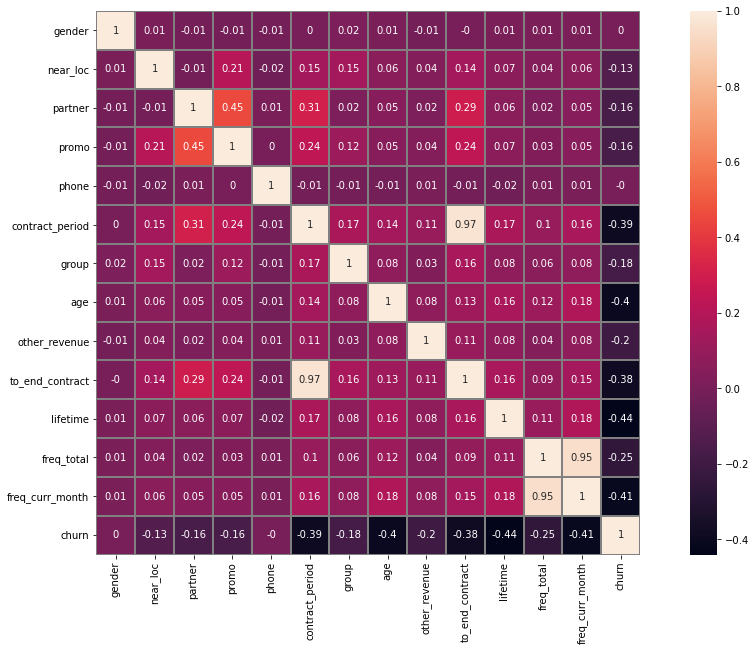

In [14]:
plt.figure(figsize= (18, 10))
                        #поменять палитру можно с помощью параметра cmap= 'coolwarm'
sns.heatmap(gym_df.corr().round(2), annot = True, square = True, linewidths=1, linecolor='gray'); #  

Очевидно наличие мультиколлинеарности в матрице наших признаков, т.к. мы имеем 2 пары очень высоко-корреллирующих между собой признаков: это параметры `общий срок контракта`  и `срок до конца контракта` , имеющие коэффициент корреляции 0,97, а также параметры `общая частота посещений` и `частота посещений в последний месяц`.  На интуитивном уровне также понятна их высокая взаимосвязь. <br>
    
   Некоторые прогнозные модели (в частности, модель логистической регресии, которую мы далее планируем использовать в исследовании) очень чувствительны к мультиколлинеарности. Потому нам следует избавиться от дублирующих признаков.<br>
    
   Среди первый двух признаков более показательным, на наш взгляд, является признак общего срока контракта, поскольку второй признак (срок до конца контракта) в большей степени зависит от точки, на которую мы делаем срез. Общий же срок контракта показывает, на сколько серьезно клиент настроен в момент покупки контракта. Так что оставляем `общий срок контракта` (удаляем `срок до конца контракта`).
    
   Аналогично со второй парой признаков: на наш взляд, показательней является частота посещений на длительном промежутке, нежели чем в послений месяц, поскольку в последний месяц может попасть отпуск клиента, и это спровоцирует на ошибочное установдение признака оттока. Оставляем `общая частота посещений` (удаляем `частота посещений в последний месяц`).<br>

In [15]:
# в датафрейме gym_df оставляем полный изначальный набор признаков, в gym сохраним данные без взаимозависимых признаков
gym = gym_df.drop('to_end_contract', axis = 1)
gym = gym.drop('freq_curr_month', axis = 1)

  
   Также найдена средняя степень взаимосвязи между признаками `пришел по акции` и `сотрудник компании - партнера` (0,45), что не является признаком мультиколлинеарности. Остальные признаки практически не имеют взаимосвязи между собой.<br>
   
   Сразу же можно увидеть **умеренную обратную взаимосвязь между показателем оттока и** такими признаками, как **срок контракта, возраст и время с момента первого обращения**: можно предположить, что **чем выше эти показатели, тем ниже отток**.

### 1.4   Распределения признаков по ушедшим в отток и оставшимся<a id='barplot_boxplot'></a> 

Поделим признаки на бинарные и остальные (небинарные).

In [16]:
binary_list = []
not_binary_list = []

for col in gym.drop('churn', axis = 1).columns:
    if gym[col].min() == 0 and gym[col].max() == 1:
        binary_list.append(col) 
    else:
        not_binary_list.append(col) 

print(binary_list)
print(not_binary_list)

['gender', 'near_loc', 'partner', 'promo', 'phone', 'group']
['contract_period', 'age', 'other_revenue', 'lifetime', 'freq_total']


Поделим с учетом полученных списков наши датафреймы на бинарные/небинарные  и добавим колонку `churn`.

In [17]:
gym_bin = gym[binary_list]
gym_not_bin = gym[not_binary_list]

gym_bin['churn'] = gym['churn']
gym_not_bin['churn'] = gym['churn']

In [18]:
display(gym_bin.head(2))
display(gym_not_bin.head(2))

,gender,near_loc,partner,promo,phone,group,churn
0,1,1,1,1,0,1,0
1,0,1,0,0,1,1,0


,contract_period,age,other_revenue,lifetime,freq_total,churn
0,6,29,14.227470,3,0.020398,0
1,12,31,113.202938,7,1.922936,0


Построим столбчатые диаграммы для каждого бинарного признака в разбивке по признаку оттока.

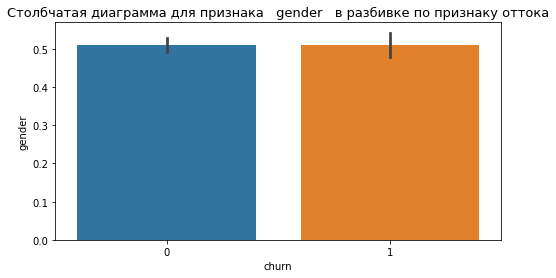

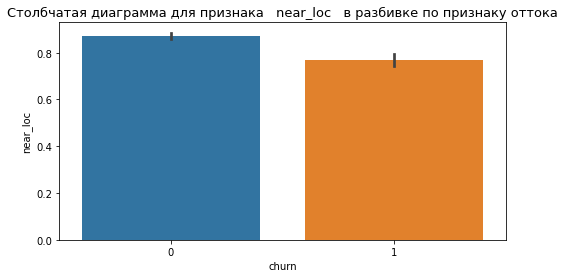

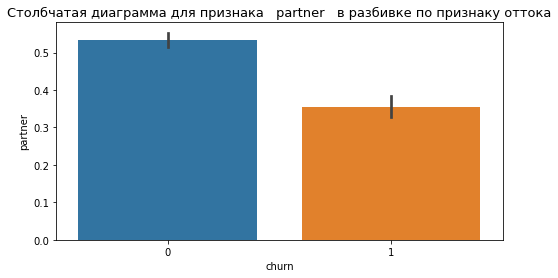

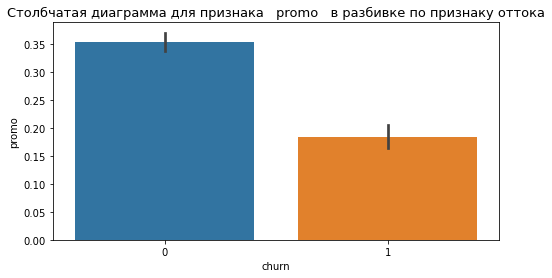

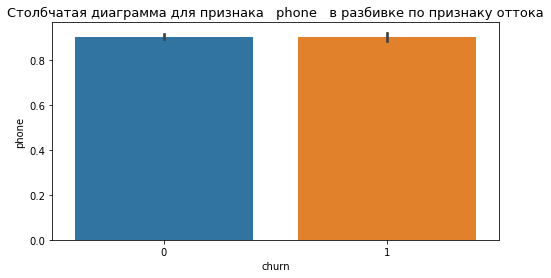

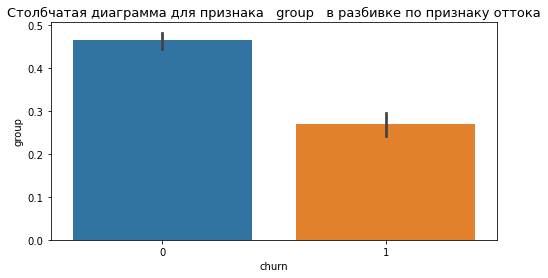

In [19]:
for col in binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Столбчатая диаграмма для признака   ' + col + '   в разбивке по признаку оттока', fontsize = 13)
    ax = sns.barplot(data = gym_bin,  x = 'churn', y = col);
    ax.yaxis.grid = True
    plt.show()

Распределения бинарных признаков в виде столбчатых диаграмм хорошо иллюстрируют все то, что мы уже смогли увидеть и описать выше по таблице средних значений признаков. Разве что можно добавить, что признак близости локации у ушедщих в отток чуть ниже, чем у оставшихся, однако различие нельзя назвать существенным.

Теперь построим диаграммы "ящик с усами" для каждого небинарного признака в разбивке по признаку оттока.

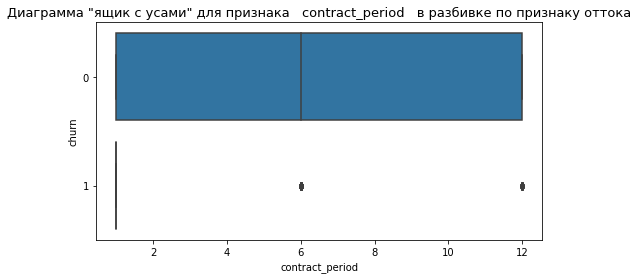

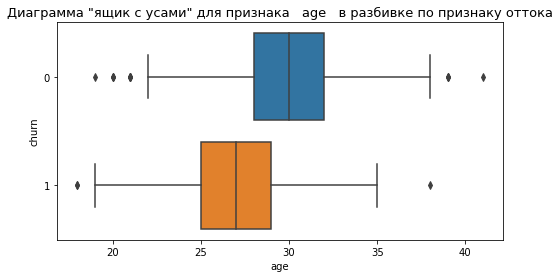

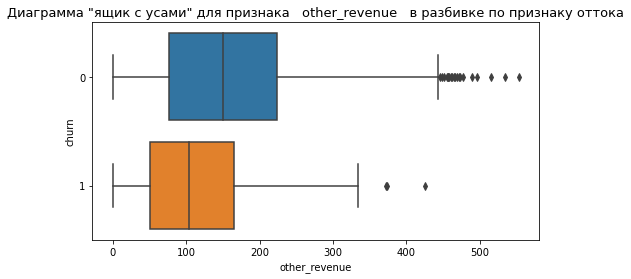

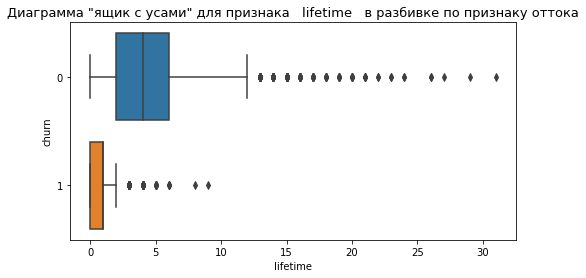

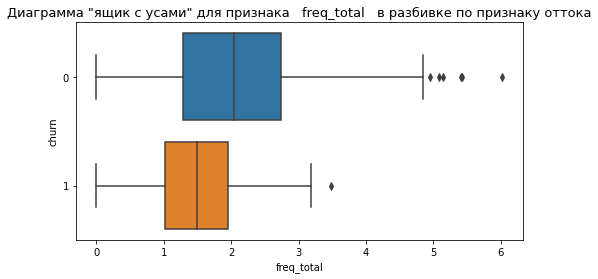

In [20]:
for col in not_binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Диаграмма "ящик с усами" для признака   ' + col + '   в разбивке по признаку оттока', fontsize = 13)
    ax = sns.boxplot(data = gym_not_bin, orient = 'h', x = col, y = 'churn')
    ax.yaxis.grid = True
    plt.show()

А вот для небинарных признаков диаграмма "ящик с усами" дает уже больше информации, чем таблица средних значений.
Почти все клиенты , ушедшие в отток имеют месячные контракты (единичные выбросы в 6 и 12 месяцев мы не считаем), в то время как у оставшихся все контракты распределены равномерно: и 1, и 6, и 12 месяцев.<br>

Медиана возраста ушедших - 27 лет, у оставшихся - 30 с лишним. В целом группа оставшихся старше группы ушедших.<br>

В основном группа оттока тратила от 50 до 160 единиц на "другие "услуги, и выбросов по тратам в этой группе мало. А вот в группе оставшихся очень много выбросов по тратам сверх 450 единиц, да и в основном эта группа потратила гораздо больше (от 80 до 230). <br>

Почти целиком группа ушедших - это "новички", знакомые с клубом до 1 месяца. Оставшиеся же ходят в клуб уже от 3 до 7 месяцев в среднем, четвертая часть их них ходят от 7 до 13 месяцев, и даже есть те, кто ходит до 30 месяцев.<br>

Частота посещения центра у  ушедших - в среднем 1,5 раза в неделю, и даже самые мотивированные из них посещали клуб  максимум 3 раза в неделю. У оставшихся медиана выше - 2 р/нед., а почти четверть группы посещала занятия от 3 до 5 р/нед.

## 2. Построение модели прогнозирования оттока пользователей<a id='binary_model'></a> 

### 2.1   Разделение и стандартизация выборок<a id='split_standart'></a> 

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце.

In [21]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis = 1)
y = gym['churn']

# разделим модель на обучающую и валидационную выборку в классическом соотношении 80% к 20% 
# укажем важный параметр random_state = 0, необходимый при повторении экспериментов и при сравнении моделей
# между собой, чтобы при делении в выборку каждый раз брались одни и те же значения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0) 

#display(X_train)
#display(y_train)

   Хотя стандартизация - это опциональный этап подготовки данных, и в данном случае при применении моделей логистической регрессии и случайного дерева её можно было бы и пропустить,  тем не менее,  её советуют проводить в любом случае, чтобы все значения были одного порядка.  Например, в случае логистической регриссии стандартизированные данные приводят коэффициенты модели к одному порядку, что упрощает анализ модели и ее использование. Также стандартизация упрощает обучение модели (именно вычисления), в случае, если модель рассчитывает коэффициенты на основе данных (хотя в случае с деревьями они не рассчитывают коэффициенты, поэтому стандартизация не влияет на вычисления так, как в логистической регрессии или при кластеризации с использованием K-Means).<br>

   Кроме того, поскольку мы строим несколько разных моделей на одних данных, а потом  сравниваем, какая из моделей лучше, то нужно для всех моделей либо стандартизированть данные, либо нет, то есть проводить вычисления на одних и тех же данных, иначе результаты моделей будут несравнимы.<br>

   Исходя из изложенного, принимаем решение стандартизировать данные. Стандартизация приведёт значения признаков к виду стандартного нормального распределения: значения будут центрированы относительно 0, а средний разброс данных составит 1. 

In [22]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
#обучаем scaler на обучающей выборке и одновременно трансформируем матрицу обучающей выборки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 

# применяем стандартизацию к матрице признаков для тестовой (а точнее, валидационной) выборки
X_test_st = scaler.transform(X_test)

X_train_st[:2]

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986, -0.84769226,  0.57944798,  0.37161711,  1.12734972,
         1.75580418],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073, -0.84769226,  0.27046055, -1.09697378,  5.88138322,
        -0.2239674 ]])

Определим функцию, которая будет выводить нужные нам метрики.

In [23]:
def print_all_metrics(y_true, y_pred, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

### 2.2  Сравнение алгоритмов логистической регрессии и случайного леса<a id='log_reg_vs_rand_for'></a> 

Зададим алгоритм для новой модели на основе алгоритма логистической регрессии, обучим модель на обучающей выборке, сделаем прогноз на валидационной выборке и посчитаем метрики.

In [24]:
lr_model = LogisticRegression(random_state = 0)
# обучим модель лог.регрессии
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# выведем все метрики
print_all_metrics(y_test, lr_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


Аналогично - для алгоритма случайного леса.

In [25]:
rf_model =  RandomForestClassifier(n_estimators = 100, random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions =  rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1] 
# выведем все метрики
print_all_metrics(y_test, rf_predictions,  title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.76


Метрика `accuracy` является одной из метрик алгоритмов бинарной классификации и означает долю верно угаданных ответов из всех прогнозов. Чем ближе значение `accuracy` к 100%, тем лучше. В нашем случае она составляет 0.90 для алгоритма логистической регрессии и 0.89 - для случайного леса. Однако, данная метрика хорошо работает только в случае, если классы сбалансированы, то есть когда объектов каждого класса примерно поровну, 50% : 50%. Но мы ранее посчитали, что в нашей задаче классы имеют соотношение 27% : 73%, то есть баланс классов не соблюден. Так как классы не сбалансированны, то эта метрика скорей показывает не то, на сколько хорошо модель предсказывает положительные исходы (единицы, или отток в нашем случае), а то, насколько хорошо она определяет превалирующий класс.

Метрика `precision` говорит, какая доля прогнозов относительно "1" класса верна. То есть смотрим долю правильных ответов только среди целевого класса (класс "оттока").  В бизнесе метрика precision нужна, если каждое срабатывание  модели ( факт отнесения к классу "1" стоит ресурсов, а бизнес не хочет, чтобы модель часто «срабатывала попусту». `Precision` составляет 0.79 для обоих алгоритмов. <br>

Метрика `recall` нацелена на минимизацию противоположных рисков:  показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Она составляет  0.81 алгоритма логистической регрессии против 0.76 у алгоритма случайного леса.<br>

Судя по метрикам, ***модель на основе алгоритма логистической регрессии показала чуть лучший результат, чем в модель на основе алгоритма случайного леса***. Поэтому, именно ее в данном случае можно было бы предложить для дальнейшего прогнозирования оттока пользователей фитнес-центра.

## 3. Кластеризация пользователей<a id='clusterisation'></a> 

### 3.1   Определение оптимального количества кластеров<a id='dendro'></a> 

Теперь проведем кластеризацию пользователей. Для этого возьмем матрицу признаков X (из нее исключен интересующий нас показатель оттока).<br>
Поскольку алгоритмы кластеризации работают с расстояниями между точками векторов признаков (наблюдений), в этом случаем стандартизация просто необходима: нужно, чтобы все признаки были приведены к одному масштабу.

In [26]:
# обязательная стандартизация данных перед работой с алгоритмами кластеризации
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Проведем иерархическую агломеративную кластеризацию и затем нарисуем дендрограмму. 

In [27]:
linked = linkage(X_sc, method = 'ward') #чтобы диаграмма получилась показательной, 
linked                                           #лучше передать параметру method значение 'ward'

array([[7.13000000e+02, 2.03300000e+03, 1.27048836e-02, 2.00000000e+00],
       [7.93000000e+02, 3.20500000e+03, 5.90387919e-02, 2.00000000e+00],
       [7.50000000e+01, 1.64600000e+03, 6.49761006e-02, 2.00000000e+00],
       ...,
       [7.98500000e+03, 7.99500000e+03, 8.41193602e+01, 2.57000000e+03],
       [7.98600000e+03, 7.99600000e+03, 8.97620484e+01, 2.95600000e+03],
       [7.99200000e+03, 7.99700000e+03, 9.53923405e+01, 4.00000000e+03]])

Получили таблицу "связок" между объектами, или матрицу попарных расстояний между точками наблюдений. Визуализируем ее как дендрограмму (дерево).

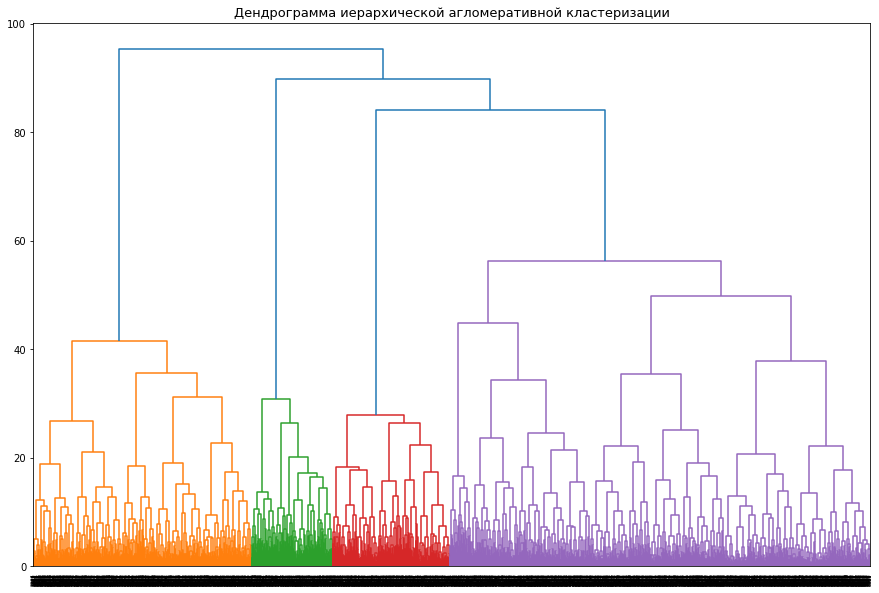

In [28]:
plt.figure(figsize=(15, 10))  
plt.title('Дендрограмма иерархической агломеративной кластеризации', fontsize = 13)
dendrogram(linked, orientation='top')
plt.show()

По вертикали  - расстояние между кластерами, а по горизонтали — объекты. Каждая горизонтальная «связка» соответствует расстоянию между объединяемыми объектами.<br>
Предложенное алгоритмом иерархической кластеризации **оптимальное число кластеров составляет 4** (4 разных цвета на графике). Хотя один из кластеров визуально гораздо больше остальных, и теоретически, можно было бы подумать о разбиении данного кластера еще на подкластеры. Вообще, деление на кластеры является отчасти творческой, экспертной задачей, и она должна согласовываться с задачами бизнеса, в том числе кластеры должны хорошо различаться и интерпретироваться. Поэтому, в данном случае я бы согласилась с предложенным моделью вариантом и остановилась бы на 4х кластерах. Однако, согласно требованию заказчика для целей сравнимости результата исследования с исследованиями других исполнителей  мы возьмем для дальнейших вычислений число кластеров, равное 5.

### 3.2   Проведение кластеризации<a id='K-means'></a>

На основании алгоритма K-means спрогнозируем кластеры клиентов.

In [29]:
# задаём модель K-means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0) 

In [30]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

In [31]:
print(labels[:10])

[4 2 3 1 1 2 4 3 1 2]


In [40]:
# сохраняем метки кластера в столбец 'cluster_km' нашего исходного датасета - gym, и датасета с признаками - Х
gym['cluster_km'] = labels
display(gym.head(3))

X['cluster_km']= labels
#display(X.head(3))

,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,lifetime,freq_total,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,2
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,3


### 3.3   Расчет доли оттока по кластерам<a id='churn_share'></a>

Для каждого кластера посчитаем количество клиентов в кластере и долю оттока.

In [33]:
churn = gym.groupby('cluster_km').agg({'cluster_km':'count', 'churn' : 'sum'}) 
churn = churn.rename(columns = {'cluster_km':'users_count', 'churn':'churn_count'})
churn['churn_share'] = (churn['churn_count'] / churn['users_count']).round(2)
churn

,users_count,churn_count,churn_share
cluster_km,,,
0,559,224,0.40
1,1066,125,0.12
2,917,22,0.02
3,1072,587,0.55
4,386,103,0.27


Больше всего склонны к оттоку клиенты кластеров "3" (55% клиентов ушла в отток в текущем месяце) и "0" (40%). А кластеры "2" и "1" являются самыми надежными (только 2 и 12% клиентов в оттоке соответственно).

Закономерностей между размером кластера и склонностью его клиентов к оттоку мы не наблюдаем: и "1", и "3" кластеры одинаково большие, но склонность к оттоку у них противоположная. Поищем другие закономерности.<br>

### 3.4  Оценка средних значений признаков по кластерам<a id='cluster_mean'></a>

Посмотрим на средние значения признаков кластеров.  

In [34]:
# выводим статистику по средним значениям наших признаков по кластеру
display(gym.groupby('cluster_km').mean())

,gender,near_loc,partner,promo,phone,contract_period,group,age,other_revenue,lifetime,freq_total,churn
cluster_km,,,,,,,,,,,,
0,0.502683,0.000000,0.490161,0.078712,1.0,3.000000,0.232558,28.708408,137.385192,3.007156,1.768159,0.400716
1,0.486867,0.996248,0.943715,0.883677,1.0,7.660413,0.523452,29.474672,149.409166,4.057223,1.912481,0.117261
2,0.561614,0.996728,0.267176,0.050164,1.0,5.241003,0.533261,30.958561,186.697490,5.778626,2.400164,0.023991
3,0.488806,1.000000,0.223881,0.078358,1.0,2.082090,0.286381,27.584888,116.455656,1.933769,1.466695,0.547575
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Мы видим, что в этой таблице средние значения показателя оттока (`churn`) по кластерам  полностью совпадает с посчитанной выше долей оттока. Это произошло потому, что наш показатель `churn` - бинарный. 

Даже просто глядя на средние значения признаков кластеров, уже многое можно заметить. Например, минимальный средний отток на уровне 2% и 12% наблюдается у кластеров под номерами "2" и "1" соответственно, при этом у  кластера "1" - максимальный средний контрактный период (7,6 месяцев), у кластера "2"  этот показатель второй по величине (5,2 месяца).<br> 
Аналогично, у данных кластеров наблюдается максимальный средний показатель `lifetime` - время с момента первого обращения в фитнес-центр: 5,8 мес. у кластера "2" и 4 мес. у кластера "1".<br>
Также показатели выручки за другие услуги (массаж, каФе и тд) у данных двух кластеров максимальны (187 и 149 единиц соответственно), что, в общем-то, логично, поскольку  данные пользователи дольше всех посещают фитнес-центр (как мы видели только что) и успели больше потратить. <br>
Средняя частота посещения также является у кластеров "2" и "1" максимальной - 2,4 раза в неделю у кластера "2" и 1,9 раз в неделю у кластера "1".<br>
Признак `group` у обоих кластеров "2" и "1" тоже максимальный - по 53% клиентов этих кластеров посещают групповые занятия. Как и признак `возраст` - 31,0 и 29,5 лет - это максимальные показатели среди кластеров.<br> 

   Наихудшим кластером по показателю оттока является кластер под номером "3" - 55% клиентов. И для большинства признаков этого кластера характерна аналогичная обратная связь: минимальные средние значения среди всех кластеров  имеет данный кластер по тем же самым признакам, для которых максимальное значение мы увидели у кластера "2" (с минимальным оттоком), а именно, следующие признаки: **контрактный период** (2 мес.),  **время с момента первого обращения** (< 2 мес.), **"другая" выручка** (116 ед.), **средняя частота посещения** - 1,5 раза в неделю,  **возраст** - 27,6 лет. И показатель **посещение групповых занятий** является для кластера "3" хоть и не минимальным, имеет ближайшее к минимуму значение - только 29% из кластера посещают занятия в группах. <br>
    
   Интересно заметить, что все вышеперечисленые признаки (кроме признака `group`) являются небинарными.<br>
   
   **Из всего вышеизложенного можно сделать предварительный вывод о том, что все вышеперечисленные признаки (небинарные) обратно-пропорционально влияют на отток клиентов: чем выше значения данных признаков, тем ниже отток, и наоборот. Соответственно, стратегия взаимодействия с пользователями и их удержания должна учитывать максимизацию перечисленных признаков.**<br>
    
   Оставшиеся признаки, на первый взгляд, не имеют особого влияния на максимальность или минимальность оттока по кластерам. Но мы еще раз посмотрим на них на графиках.<br>

### 3.5   Распределения признаков по кластерам<a id='cluster_bar_boxplot'></a>

Теперь построим графики распределения с учетом разбиения по кластерам и посмотрим, что мы увидим по ним. <br>
Для построения графиков опять поделим наш датафрейм на два: с бинарными и небинарными признаками, и добавим недостающие колонки. 

In [35]:
gym_bin_cl = gym[binary_list]
gym_not_bin_cl = gym[not_binary_list]

gym_bin_cl['churn'] = gym['churn']
gym_not_bin_cl['churn'] = gym['churn']
gym_bin_cl['cluster_km'] = gym['cluster_km']
gym_not_bin_cl['cluster_km'] = gym['cluster_km']

In [36]:
display(gym_bin_cl.head(2))
display(gym_not_bin_cl.head(2))

,gender,near_loc,partner,promo,phone,group,churn,cluster_km
0,1,1,1,1,0,1,0,4
1,0,1,0,0,1,1,0,2


,contract_period,age,other_revenue,lifetime,freq_total,churn,cluster_km
0,6,29,14.227470,3,0.020398,0,4
1,12,31,113.202938,7,1.922936,0,2


In [37]:
print(gym_bin_cl.shape)
print(gym_not_bin_cl.shape)

(4000, 8)
(4000, 7)


Посмотрим на распределения небинарных признаков в разбивке по кластерам.

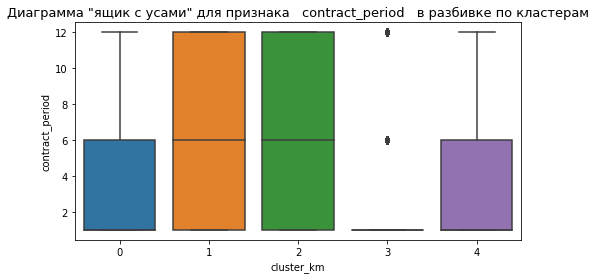

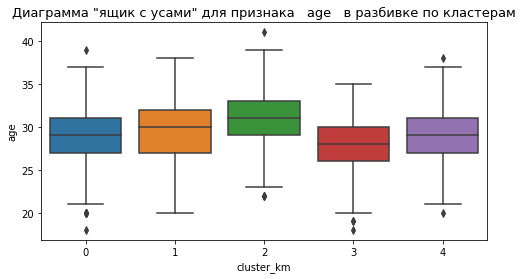

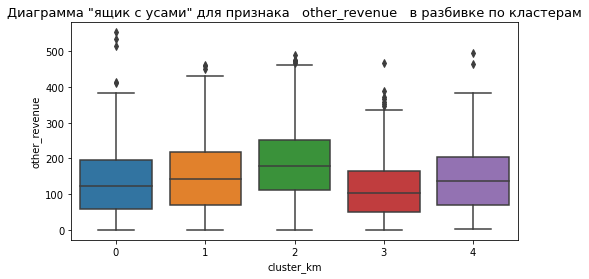

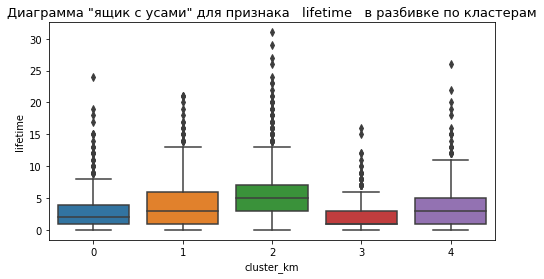

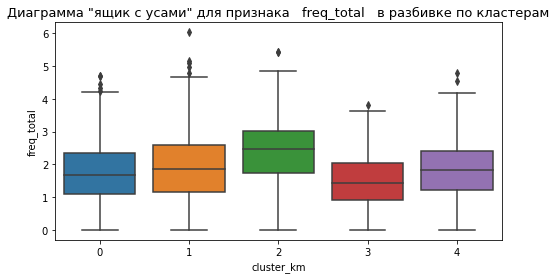

In [38]:
for col in not_binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Диаграмма "ящик с усами" для признака   ' + col + '   в разбивке по кластерам', fontsize = 13)
    ax = sns.boxplot(data = gym_not_bin_cl, y = col, x = 'cluster_km')
    ax.yaxis.grid = True
    plt.show()

По диаграммам "ящика с усами" мы можем видеть, что все клиенты наиболее склонного к оттоку кластера "3" имеют месячные контракты (единичные выбросы в 6 и 12 месяцев мы не считаем), в то время как в наиболее надежных кластерах "2" и "1" все контракты распределены равномерно: и 1, и 6, и 12 месяцев.  
Основная часть контрактов "0" и "4" кластеров составляет 1 и 6 месяцев - их графики идентичны.<br>

Клиенты самого надежного кластера "2" имеют в целом более зрелый возраст (медиана примерно на уровне 30,5 лет, три четверти клиентов - старше 29 лет), чем у наименее надежного кластера "3" (медиана на уровне 28 лет, три четверти клиентов - старше 27 лет). То есть возрастной сдвиг между пограничными кластерами - 2-3 года. 
Можно заметить идентичность кластеров "0" и "4"  по данному признаку.<br>

Основная масса значений кластера "2" по признаку "другая выручка" (медиана - 190) расположена выше основной массы значений кластера "3" (медиана - 110), то есть клиенты более надежного кластера тратят больше денег и на другие попутные услуги клуба. Также отмечаем полную идентичность кластеров "0" и "4" по данному признаку.<br>

По признаку `lifetime` три четверти значений кластеры "2" располагаются выше , чем три четверти значений кластера "3": подавляющее большинство самого надежного кластера "2" знакомы с клубом от 3 до 13 месяцев в пртивовес "ненажежному " кластеру, у которого большинство клиентов - новенькие (lifetime менее 3 мес.)<br>
Кластеры "0" и "4" по данному признаку не идентичны, но наиболее близки между собой.<br>

По частоте посещения опять же кластер "2" показывает наилучшие результаты: медиана ~2,6 раз в неделю и межквартильный размах от 1,5 до 3 р/нед. против медианы 1,6 р/нед и межквартильного размаза от 1 до 2 р/нед у кластера "3". Значения кластеров "0", "1" и "4" примерно совпадают, причем у "0" и "4" они почти полностью идентичны, как и по другим признакам.<br>

**В целом по графикам распределения небинарных признаков можно сделать вывод о том, кластер "2" (наилучший по показателю оттока) имеет наивысшие значения небинарных признаков, кластер "3" (наихудший по оттоку) - имеет наименьшие значения. Кластер "1" имеет наибольший размах значений признаков (вероятно, и потому, что он почти наикрупнейший по размеру кластер). Кластеры "0" и "4" практически полностью индентичны по всем небинарным признакам**.

Посмотрим на распределения бинарных признаков в разбивке по кластерам.

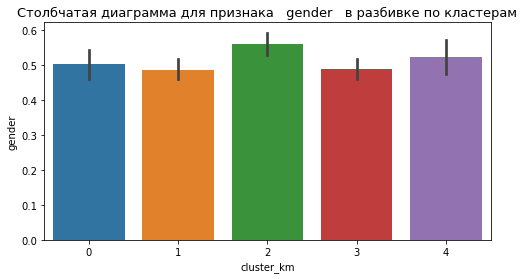

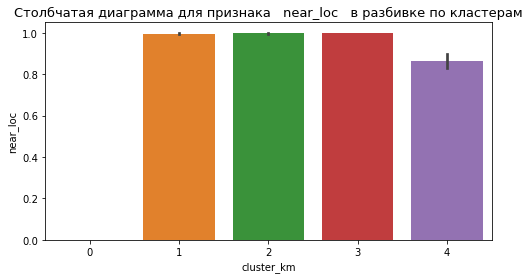

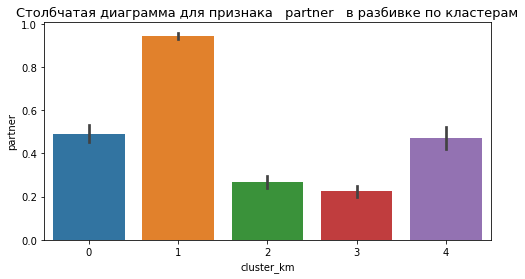

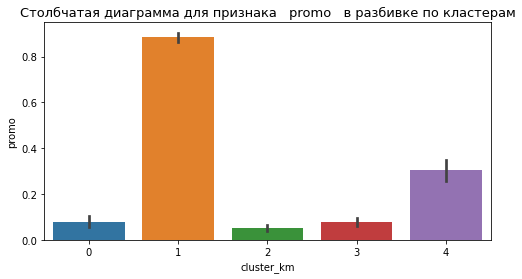

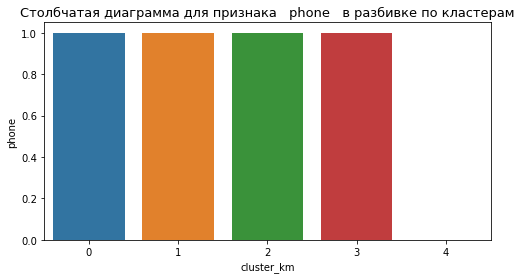

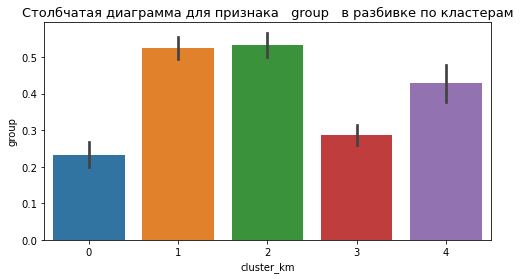

In [39]:
for col in binary_list:
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('Столбчатая диаграмма для признака   ' + col + '   в разбивке по кластерам', fontsize = 13)
    ax = sns.barplot(data = gym_bin_cl,  x = 'cluster_km', y = col);
    ax.yaxis.grid = True
    plt.show()

По признаку `возраст` почти все кластеры индентичны, обращает на себя внимание лишь "наилучший" по оттоку кластер "2": в нем 56% клиентов пола под кодом №1. Это примерно на 7-15% больше, чем в других кластерах. Неважно, мужчины это или женщины, а важно то, что, клиенты именно этого пола имеют большую стойкость в следовании своим решениям по поддержанию здоровья и фигуры.  То есть, **еще одной рекомендацией мог бы служить совет обратить бОльшее внимание на привлечение клиентов пола "1", например, путем запуска специфических для этого пола промоакций.**<br>

По признаку `близость локации` можно сказать, что клиенты первого, второго и третьего кластеров полностью живут или работают в непосредственной близости от фитнес-центра, то есть данный признак никак нельзя назвать определяющим в вопросе оттока. Можно заметить лишь , что кластер "0" сформирован по принципу дальней локации для всех клиентов кластера.<br>

По признаку `сотрудник партнера` кластер "1" почти полностью состоит из таких клиентов, и при этом он показывает второй по надежности показатель (12% оттока). Хотя назвать этот показатель сильно определяющим нельзя, поскольку он почти одинаково низкий у наилучшего и наихудшего кластеров ("2" и "3"). Кластеры "0" и "4" полностью идентичны по данному признаку (по половине клиентов являются сотрудниками компаний-партнеров). <br>

Тоже самое касается и признака `promo`: кластер "1" на 90% состоит из таких клиентов, при этом кластеры "2", "3" и "0" имеют рекордно низкие показатели - менее 10%. Таким образом, фактор прихода по акции "Приведи друга" тоже не является определяющим.<br>

По столбчатой диаграмме признака `phone` можно увидеть, что, опять же наличие в базе телефона клиентов показывают все кластеры, кроме четвертого, то есть этот признак так же не является определяющим. Тем не менее, поскольку четвертый кластер имеет показатель оттока 27%, **еще одна рекомендация  менеждерам отдела продаж  - проверить, не является ли отсутствие номера в базе упущением при заключении контракта, или же клиент просто выбрал другой предпочтительный канал связи (например, емейл)**.<br>

Признак `group`, пожалуй, единственный бинарный признак, который имеет значение влияние на формирование оттока: в наилучшем кластере "2" 53% клиентов посещали групповые занятия, а в наихудшем - лишь 29%. Кластер "1", занимающий второе мето по надежности (12% оттока) тоже имеет высокий групповой показатель - 52%. Налицо, опять же, обратная связь с оттоком.<br>

**В общем, по бинарным признакам можно сделать вывод, что все они (кроме признака `group`) не являются определяющими в формировании оттока**.<br>

Можно сделать интересное наблюдение, что кластеры "0" и "4" практически полностью идентичны, и отличаются лишь полным отсутствием телефонов клиентов в кластере "4", и полностью удаленной локацией клиентов кластера "0". В остальном  эти кластеры очень похожи, и их без особого ущерба для результатов исследования можно было бы объединить в один. Это подтвержает наше экспертное мнение о достаточности 4 классов вместо 5ти.<br>


## 4. Выводы<a id='conclusions'></a>

В данном проекте проведено исследование данных пользователей фитнес-центра с целью прогнозирования оттока пользователей.<br>

В ходе сравнения двух групп пользователей - ушедших в отток и оставшихся - было выяснено, что:
- оставшиеся пользователи имеют значения большинства признаков выше (на 30% - 500%), чем значения данных признаков у группы ушедших в отток;
- эти признаки - общий срок контракта  и срок до конца контракта,  возраст, выручка от "других" услуг. частота посещения всего и частота посещений в последний месяц, "время жизни", посещаемость групповых занятий, приход по промоакции "Приведи друга", причастность к компании-партнеру;
- соотношение полов и наличие телефона в базе различия по группам не имеют.<br>

В процессе исследования взаимозависимостей признаков была выявлена мультиколлинерность признаков и определено, что такие признаки как "частота посещения в последний месяц" и "срок до конца контракта" можно удалиьт из рассмотрения без ущерба для результатов анализа.<br>

Для прогнозирования оттока пользователей (на уровне следующего месяца) были построены и протестированы две модели бинарной классификации - с помощью алгоритмов логистической регрессии и случайного леса. На основании метрик доля правильных ответов, точность и полнота (accuracy, precision, recall) модель логистической регресии была признана более точной.<br>

Далее с помощью алгоритмов агломеративной иерархической кластеризации и K-means была проведена сегментация пользователей на 5 кластеров. Было проведено сравнение признаков по данным кластерам. В результате определены два кластера с характерными значениями признаков для группы, наиболее склонной к оттоку, и наиболее надежной группы.<br>

Таким образом на основании анализ кластеров можно выделить 2 наиболее яркие группы клиентов - надежных и склонных к оттоку, и сформулировать для них характерные признаки.

**Наиболее надежными клиентами являются клиенты группы с максимальными небинарными признаками** (максимальным возрастом, длиной контракта, сроком "жизни" в фитнес-центре,  выручкой по прочим услугам, средней частотой посещения), **а также с максимальным процентом посещения групповых занятий**. Они не пришли по промоакции, живут или работают рядом, их номер телефона есть в базе клуба, они, в основном, не являются сотрудниками компаний-партнеров, и **количество клиентов пола №1 в этой группе превышает остальные группы (кластеры) в среднем на 10% процентов**.

**Наименее надежными клиентами (более всего склонными к оттоку) являются, наоборот, клиенты группы с минимальными небинарными признаками**: минимальным возрастом, длиной контракта, сроком "жизни" в фитнес-центре,  выручкой по прочим услугам, средней частотой посещения, **а также с почти минимальным процентом посещения групповых занятий**. Они также, как и клиенты "надежной" группы, не пришли по промоакции, в основном, не являются сотрудниками компаний-партнеров, тоже живут или работают рядом, их номер телефона тоже есть в базе клуба,  а количество клиентов обоих поло в этой группе примерно одинаковое.

Можно проследить взаимосвязь. **Чем менее склонен клиент к оттоку, тем более высокое значение  имеют у него определяющие признаки, а именно:**
- старше его возраст (и больше мотивации поддердивать фигуру и здоровье);
- длиннее срок контракта (вероятно, жаль бросить, раз заплатил больше денег, либо же принято более осознанное решение о поддержке фигуры или здоровья);
- чаще посещает фитнес-центр;
- является более давним клиентом;
- больше тратит на "другие" услуги центра;
- чаще посещает групповые занятия;
- он с бОльшей вероятностью принадлежит к полу №1.

## 5. Рекомендации<a id='recommendations'></a> 

**Целевой группой будет являться наиболее склонная к оттоку группа. Комплекс маркетинговых мероприятий рекомендуется направить на увеличение значений вышеперечисленных определяющих признаков для данной группы.**
Например,
- скидки на более "длинные" контракты (абонементы);
- специализированная акция для привелечения клиентов пола №1;
- промоакция для потенциальных клиентов возраста старше 30 лет;
- "связанные" акции, например, скидочные предложения на "другие" услуги центра при покупке максимально "длинного" контракта;
- стимуляция более частых посещений центра и/или групповых занятих (например, 9 занятий посетил - 10е в подарок, или 3 занятия в будни - в выходной посещение бесплатно);
- преференции более давним клиентам.

Также **рекомендуется провести анализ причин отсутствия телефонов в базе фитнес-центра** части пользователей: является ли это оплошностью менеждеров при заключении контрактов, либо же клиентами выбран альтернативный канал связи (емейл). 